# Correlated Truncation Errors in for Realistic NN Interactions in Chiral Effective Field Theory

This notebook provides the code to reproduce all of the plots from Melendez et al. (2019).
Notebook written by Jordan Melendez.
Commentary by Daniel Phillips and Dick Furnstahl, June 2019.


*Note*: Since publication we have switched the `pivoted_cholesky` function from an underlying GSL to a LAPACK routine.
Their output is generally identical but the exact results can differ very slightly depending on fine details of the input matrix.
Thus some of the PC plots may not be identical to their published versions, but the overall conclusions remain unchanged. (Currently only Fig. 7(c) has changed.)

In [1]:
import gsum as gm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import os
import h5py
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import urllib
import tables

%matplotlib inline

In [2]:
# See: https://ianstormtaylor.com/design-tip-never-use-black/
# softblack = '#262626'
softblack = 'k'  # Looks better when printed on tex file
gray = '0.7'

mpl.rcParams['figure.dpi'] = 180
mpl.rcParams['font.size'] = 9
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['axes.edgecolor'] = softblack
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.labelcolor'] = softblack
mpl.rcParams['axes.linewidth']

mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['xtick.color'] = softblack
mpl.rcParams['ytick.color'] = softblack
mpl.rcParams['xtick.minor.size'] = 2.4
mpl.rcParams['ytick.minor.size'] = 2.4

mpl.rcParams['legend.title_fontsize'] = 9
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderaxespad'] = 0.8
mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

text_bbox = dict(boxstyle='round', fc=(1, 1, 1, 0.6), ec=softblack, lw=0.8)
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='pdf')

In [3]:
cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']]
colors = [cmap(0.55 - 0.1 * (i==0)) for i, cmap in enumerate(cmaps)]
light_colors = [cmap(0.25) for cmap in cmaps]

edgewidth = 0.6

In [4]:
def regular_train_test_split(x, dx_train, dx_test, offset_train=0, offset_test=0, xmin=None, xmax=None):
    train_mask = np.array([(i - offset_train) % dx_train == 0 for i in range(len(x))])
    test_mask = np.array([(i - offset_test) % dx_test == 0 for i in range(len(x))])
    if xmin is None:
        xmin = np.min(x)
    if xmax is None:
        xmax = np.max(x)
    train_mask = train_mask & (x >= xmin) & (x <= xmax)
    test_mask = test_mask  & (x >= xmin) & (x <= xmax) & (~ train_mask)
    return train_mask, test_mask

In [5]:
def offset_xlabel(ax):
    ax.set_xticks([0])
    ax.set_xticklabels(labels=[0], fontdict=dict(color='w'))
    ax.tick_params(axis='x', length=0)
    return ax

## NN Scattering in Chiral EFT

In the last section of the paper we turn our attention to NN scattering in Chiral EFT. We apply the above ideas to the differential cross section vs angle at $E_{\rm lab}=150$ MeV, to the total cross section vs energy, and to the spin observable $A$ at 96 MeV.

In [6]:
# Constants: proton/neutron masses and hbar
m_p = 938.27208  # MeV/c^2
m_n = 939.56541  # MeV/c^2
hbarc = 197.33  # Mev-fm


def E_to_p(E_lab, interaction):
    """Return p in MeV.

    Parameters
    ----------
    energy      = float
                  lab energy given in MeV.
    interaction = str
                  {"pp", "nn", "np"}
    """

    if interaction == "pp":
        m1, m2 = m_p, m_p
    if interaction == "nn":
        m1, m2 = m_n, m_n
    if interaction == "np":
        m1, m2 = m_n, m_p
    p_rel = np.sqrt(
        E_lab * m2**2 * (E_lab + 2 * m1) /
        ((m1 + m2)**2 + 2 * m2 * E_lab)
        )
    return p_rel


def Q_approx(E, Lambda_b, interaction='np', single_expansion=False):
    if single_expansion:
        m_pi = 0
    else:
        m_pi = 138  # Set to 0 to just return p/Lambda_b
    # Interpolate to smooth the transition from m_pi to p
    n = 8
    p = E_to_p(E, interaction)
    q = (m_pi**n + p**n) / (m_pi**(n-1) + p**(n-1)) / Lambda_b
    return q

In [7]:
# We get the NN data from a separate place in our github respository.
nn_url = 'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/scattering_observables_RKE_L-550MeV.h5?raw=true'

response = urllib.request.urlopen(nn_url) 
h5file = tables.open_file("nn_observables_eft.h5", driver="H5FD_CORE",
                          driver_core_image=response.read(),
                          driver_core_backing_store=0)
SGT = h5file.get_node('/SGT').read()
DSG = h5file.get_node('/DSG').read()
AY = h5file.get_node('/PB').read()
A = h5file.get_node('/A').read()
D = h5file.get_node('/D').read()
AXX = h5file.get_node('/AXX').read()
AYY = h5file.get_node('/AYY').read()
q_cm = h5file.get_node('/q_cm').read()
t_lab = h5file.get_node('/t_lab').read()
degrees = h5file.get_node('/degrees').read()

q_cm *= hbarc

nn_online_pot = 'pwa93'
nn_online_url = 'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/NN-online-Observables.h5?raw=true'
nno_response = urllib.request.urlopen(nn_online_url) 
nn_online_file = tables.open_file("nn_online_example.h5", driver="H5FD_CORE",
                          driver_core_image=nno_response.read(),
                          driver_core_backing_store=0)
SGT_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/SGT').read()
print(SGT_nn_online.shape)
DSG_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/DSG').read()[:, :-1]
AY_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/PB').read()[:, :-1]
A_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/A').read()[:, :-1]
D_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/D').read()[:, :-1]
AXX_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/AXX').read()[:, :-1]
AYY_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/AYY').read()[:, :-1]

(350,)


In [8]:
if "EKM" in nn_url:
    nn_orders = np.array([0, 2, 3, 4, 5])
    cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']]
    
    potential_string = "EKM"
    
    if "0p8" in nn_url:
        cutoff_string = "0p8fm"
    elif "0p9" in nn_url:
        cutoff_string = "0p9fm"
    elif "1p0" in nn_url:
        cutoff_string = "1p0fm"
    elif "1p1" in nn_url:
        cutoff_string = "1p1fm"
    elif "1p2" in nn_url:
        cutoff_string = "1p2fm"
    
if "RKE" in nn_url:
    nn_orders = np.array([0, 2, 3, 4, 5, 6])
    cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples']]
    
    potential_string = "RKE"
    
    if "400" in nn_url:
        cutoff_string = "400MeV"
    elif "450" in nn_url:
        cutoff_string = "450MeV"
    elif "500" in nn_url:
        cutoff_string = "500MeV"
    elif "550" in nn_url:
        cutoff_string = "550MeV"
        
if "EM" in nn_url:
    nn_orders = np.array([0, 2, 3, 4, 5])
    cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']]
    
    potential_string = "EMN"
    
    if "450" in nn_url:
        cutoff_string = "450MeV"
    elif "500" in nn_url:
        cutoff_string = "500MeV"
    elif "550" in nn_url:
        cutoff_string = "550MeV"

# This ensures we only analyze the non-trivial information at
# O(Q^2), O(Q^3), O(Q^4), and O(Q^5)
excluded = [0]
nn_orders_mask = ~ np.isin(nn_orders, excluded)
Deg = degrees[:, None]
Lambdab = 600

In [9]:
colors = [cmap(0.55 - 0.1 * (i==0)) for i, cmap in enumerate(cmaps)]
light_colors = [cmap(0.25) for cmap in cmaps]

### Figure 11: Differential Cross Section


In [84]:
# Define the kinematics of the dcs we are analyzing
t_lab_dsg = 50  # should match up with legend title in curve plot
t_lab_idx_dsg = np.nonzero(t_lab_dsg == t_lab)[0][0]
q_cm_dsg = q_cm[t_lab_idx_dsg]

deg_train_mask_dsg, deg_valid_mask_dsg = regular_train_test_split(degrees, dx_train=30, dx_test=10)
ratio_dsg = Q_approx(t_lab_dsg, Lambda_b=Lambdab)

dsg_train = DSG.T[deg_train_mask_dsg, t_lab_idx_dsg]
dsg_valid = DSG.T[deg_valid_mask_dsg, t_lab_idx_dsg]
dsg_vs_theta = DSG.T[:, t_lab_idx_dsg]
dsg_ref = dsg_vs_theta[:, -1]
# print(dsg_vs_theta[0, -1])

# Compute the coefficients and define the kernel
coeffs_dsg = gm.coefficients(dsg_vs_theta, ratio=ratio_dsg, ref=dsg_ref, orders=nn_orders)[:, nn_orders_mask]
length_scale_dsg = 40
if t_lab_dsg == 50:
    kernel_dsg = RBF(length_scale=length_scale_dsg, length_scale_bounds=(20, 60)) + \
                WhiteKernel(1e-8, noise_level_bounds='fixed')
else:
    kernel_dsg = RBF(length_scale=length_scale_dsg, length_scale_bounds=(20, 60)) + \
                WhiteKernel(1e-10, noise_level_bounds='fixed')

center0 = 0
disp0 = 0
df0 = 1
scale0 = 1

gp_dsg = gm.ConjugateGaussianProcess(
    kernel_dsg, center=center0, disp=disp0, df=df0,
    scale=1, n_restarts_optimizer=10)

C:\Users\pjmil\anaconda3\lib\site-packages\gsum\models.py:665: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)


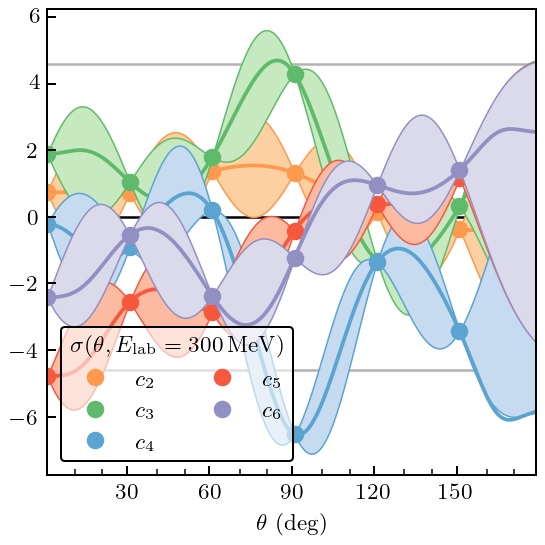

In [85]:
gp_dsg.fit(Deg[deg_train_mask_dsg], coeffs_dsg[deg_train_mask_dsg])
pred, std = gp_dsg.predict(Deg, return_std=True)
underlying_std = np.sqrt(gp_dsg.cov_factor_)

fig, ax = plt.subplots(figsize=(3.2, 3.2))
for i, n in enumerate(nn_orders[1:]):
    ax.plot(degrees, pred[:, i], c=colors[i], zorder=i-6, ls='--')
    ax.plot(degrees, coeffs_dsg[:, i], c=colors[i], zorder=i-5)
    ax.plot(degrees[deg_train_mask_dsg], coeffs_dsg[deg_train_mask_dsg, i], c=colors[i], zorder=i-5,
            ls='', marker='o', label=r'$c_{}$'.format(n))
    ax.fill_between(degrees, pred[:, i] + 2*std, pred[:, i] - 2*std, zorder=i-5,
                     facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=1)


# Format
ax.axhline(2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(-2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(0, 0, 1, c=softblack, zorder=-10, lw=1)
ax.set_xticks(degrees[deg_valid_mask_dsg], minor=True)
ax.set_xticks([30, 60, 90, 120, 150])
ax.tick_params(which='minor', bottom=True, top=False)
ax.set_xlabel(r'$\theta$ (deg)')
ax.legend(ncol=2, borderpad=0.4,# labelspacing=0.5, columnspacing=1.3,
          borderaxespad=0.6,
          title=r'$\sigma(\theta, E_{\mathrm{lab}}=50\,\mathrm{MeV})$')
fig.tight_layout();
fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \
            'dsg_interp_and_underlying_processes' + '_' + str(t_lab_dsg) + 'MeVlab' + \
            '_' + potential_string + '_' + cutoff_string)

And then things follow as before: print out the kernel, define the mean and covariance, do the diagnostics, and plot Mahalanobis distance and Pivoted Cholesky errors.

In [86]:
gp_dsg.kernel_

RBF(length_scale=20) + WhiteKernel(noise_level=1e-10)

In [87]:
mean_dsg = gp_dsg.mean(Deg[deg_valid_mask_dsg])
cov_dsg = gp_dsg.cov(Deg[deg_valid_mask_dsg])
# print(cov_dsg)
gr_dgn_dsg = gm.GraphicalDiagnostic(coeffs_dsg[deg_valid_mask_dsg], mean_dsg, cov_dsg, colors=colors,
                                    gray=gray, black=softblack)

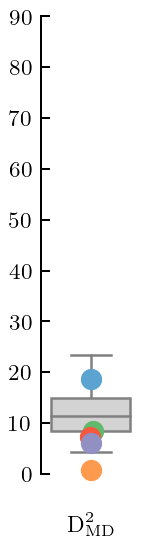

In [88]:
MD_label = r'$\mathrm{D}_{\mathrm{MD}}^2$'
PC_label = r'$\mathrm{D}_{\mathrm{PC}}$'

fig, ax = plt.subplots(figsize=(1, 3.2))
gr_dgn_dsg.md_squared(type='box', trim=False, title=None, xlabel=MD_label)
offset_xlabel(ax)
ax.set_ylim(0, 90)
fig.tight_layout();
fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \
            'dsg_md' + '_' + str(t_lab_dsg) + 'MeVlab' + '_' + \
            potential_string + '_' + cutoff_string)

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


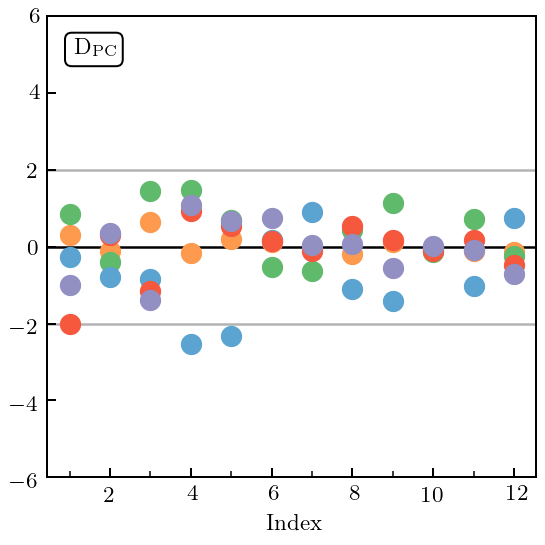

C:\Users\pjmil\AppData\Local\Temp/ipykernel_24188/4146506951.py:10: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \


In [89]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(figsize=(3.2, 3.2))
    gr_dgn_dsg.pivoted_cholesky_errors(ax=ax, title=None)
    ax.set_xticks([2, 4, 6, 8, 10, 12])
    ax.set_xticks([1, 3, 5, 7, 9, 11], minor=True)
    ax.text(0.05, 0.95, PC_label, bbox=text_bbox, transform=ax.transAxes, va='top', ha='left')
    ax.set_ylim(-6, 6)
    fig.tight_layout();
    plt.show()
    fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \
            'dsg_pc_vs_index' + '_' + str(t_lab_dsg) + 'MeVlab' + '_' + \
                potential_string + '_' + cutoff_string)

### Figure 9: The $Q$ and $\ell$ Posterior

Here we generate the 2D posterior for the EFT expansion parameter $Q$ and the GP lengthscale $\ell$.
We also show the 1D marginal distributions for $\Lambda_{b}$ and $\ell$. And all in one plot!

In [90]:
# Define the grid on which we want to plot the results
ls_vals = np.linspace(1e-6, 100, 100)
lambda_vals = np.linspace(300, 900, 300)

In [91]:
# gp_A = gm.TruncationGP(kernel_A, ref=1, ratio=ratio_A, center=center0, 
#     disp=disp0, df=df0, scale=scale0, excluded=excluded)
# gp_dsg = gm.ConjugateGaussianProcess(
#     kernel_dsg, center=center0, disp=disp0, df=df0,
#     scale=1, n_restarts_optimizer=10)
gp_dsg = gm.TruncationGP(kernel_dsg, ref=dsg_vs_theta[0, -1], ratio=ratio_dsg, center=center0, \
                         disp=disp0, df=df0, scale=1, excluded=excluded)
gp_dsg.fit(degrees[deg_train_mask_dsg][:, None], dsg_train, orders=nn_orders, \
         dX=np.array([[0]]), dy=[0])

# Compute the log likelihood for values on this grid. 
ls_lambda_loglike = np.array([[
    gp_dsg.log_marginal_likelihood( theta=[ls_,], ratio = Q_approx(t_lab_dsg, Lambda_b = lambd) ) \
    for ls_ in np.log(ls_vals)]
    for lambd in lambda_vals])

C:\Users\pjmil\anaconda3\lib\site-packages\gsum\models.py:665: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)


In [92]:
# Makes sure that the values don't get too big or too small
ls_lambda_like = np.exp(ls_lambda_loglike - np.max(ls_lambda_loglike))

# Now compute the marginal distributions
lambda_like = np.trapz(ls_lambda_like, x = ls_vals, axis = -1)
ls_like = np.trapz(ls_lambda_like, x = lambda_vals, axis = 0)

# Normalize them
lambda_like /= np.trapz(lambda_like, x = lambda_vals, axis = 0)
ls_like /= np.trapz(ls_like, x = ls_vals, axis = 0)

In [93]:
def joint_plot(ratio = 1, height = 3):
    """Taken from Seaborn JointGrid"""
    fig = plt.figure(figsize=(height, height))
    gsp = plt.GridSpec(ratio+1, ratio+1)

    ax_joint = fig.add_subplot(gsp[1:, :-1])
    ax_marg_x = fig.add_subplot(gsp[0, :-1], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(gsp[1:, -1], sharey=ax_joint)

    # Turn off tick visibility for the measure axis on the marginal plots
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Turn off the ticks on the density axis for the marginal plots
    plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_x.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    ax_marg_x.yaxis.grid(False)
    ax_marg_y.xaxis.grid(False)

    # Make the grid look nice
    from seaborn import utils
    # utils.despine(fig)
    utils.despine(ax=ax_marg_x, left=True)
    utils.despine(ax=ax_marg_y, bottom=True)
    fig.tight_layout(h_pad=0, w_pad=0)
    
    ax_marg_y.tick_params(axis='y', which='major', direction='out')
    ax_marg_x.tick_params(axis='x', which='major', direction='out')
    ax_marg_y.tick_params(axis='y', which='minor', direction='out')
    ax_marg_x.tick_params(axis='x', which='minor', direction='out')
    ax_marg_y.margins(x=0.1, y=0.)

    fig.subplots_adjust(hspace=0, wspace=0)
    
    return fig, ax_joint, ax_marg_x, ax_marg_y

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


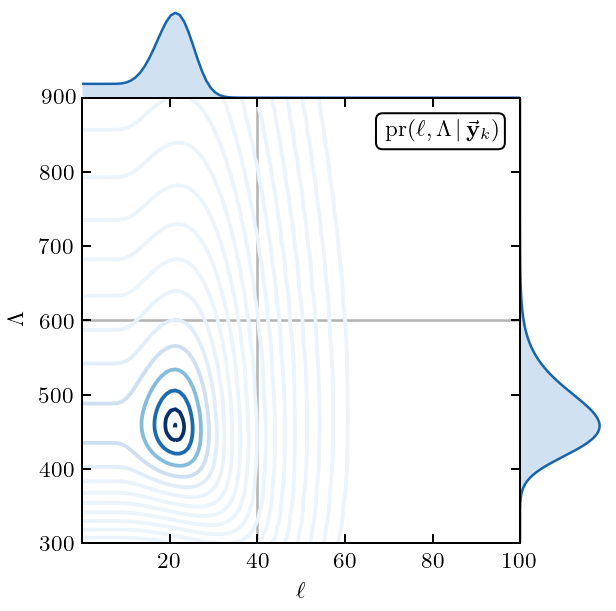

C:\Users\pjmil\AppData\Local\Temp/ipykernel_24188/1492094096.py:41: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \


In [94]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    cmap_name = 'Blues'
    cmap = mpl.cm.get_cmap(cmap_name)

    # Setup axes
    fig, ax_joint, ax_marg_x, ax_marg_y = joint_plot(ratio=5, height=3.4)

    # Plot contour
    ax_joint.contour(ls_vals, lambda_vals, ls_lambda_like,
                     levels=[np.exp(-0.5*r**2) for r in np.arange(9, 0, -0.5)] + [0.999],
                     cmap=cmap_name, vmin=-0.05, vmax=0.8, zorder=1)

    # Now plot the marginal distributions
    ax_marg_y.plot(lambda_like, lambda_vals, c=cmap(0.8), lw=1)
    ax_marg_y.fill_betweenx(lambda_vals, np.zeros_like(lambda_like),
                            lambda_like, facecolor=cmap(0.2), lw=1)
    ax_marg_x.plot(ls_vals, ls_like, c=cmap(0.8), lw=1)
    ax_marg_x.fill_between(ls_vals, np.zeros_like(ls_vals),
                           ls_like, facecolor=cmap(0.2), lw=1)

    # Formatting
    ax_joint.set_xlabel(r'$\ell$')
    ax_joint.set_ylabel(r'$\Lambda$')
    ax_joint.axvline(length_scale_dsg, 0, 1, c=gray, lw=1, zorder=0)
    ax_joint.axhline(Lambdab, 0, 1, c=gray, lw=1, zorder=0)
    ax_joint.margins(x=0, y=0.)
    ax_joint.set_xlim(min(ls_vals), max(ls_vals))
    ax_joint.set_ylim(min(lambda_vals), max(lambda_vals))
#     ax_joint.set_xticks([0.1, 0.2, 0.3])
#     ax_joint.set_xticks([0.15, 0.25], minor=True)
#     ax_joint.set_yticks([0.4, 0.5, 0.6])
#     ax_joint.set_yticks([0.35, 0.45, 0.55, 0.65], minor=True)
    ax_marg_x.set_ylim(bottom=0);
    ax_marg_y.set_xlim(left=0);
    ax_joint.text(0.95, 0.95, r'pr$(\ell, \Lambda \,|\, \vec{\mathbf{y}}_k)$', ha='right', va='top',
                  transform=ax_joint.transAxes,
                  bbox=text_bbox
                 );

    plt.show()
    fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \
            'Lambda_ell_jointplot' + '_' + 'DSG' + '_' + str(t_lab_dsg) + 'MeVlab' + '_' + \
                potential_string + '_' + cutoff_string)

### Figure 12: Total Cross Section

In [21]:
# Split into training and testing data
tlab_train_mask_sgt, tlab_valid_mask_sgt = regular_train_test_split(t_lab, dx_train=100, dx_test=25, xmin=100)
# print(tlab_train_mask_sgt)
# print(tlab_valid_mask_sgt)

# Define Q at each t_lab
ratio_sgt = Q_approx(t_lab, Lambda_b=Lambdab)

Tlab = t_lab[:, None]
# print(Tlab.shape)

sgt_train = SGT.T[tlab_train_mask_sgt]
# print(sgt_train.shape)
sgt_valid = SGT.T[tlab_valid_mask_sgt]
# print(sgt_valid.shape)
sgt_ref = SGT[0]
print(sgt_ref[tlab_valid_mask_sgt])

# Extract the coefficients and define kernel
coeffs_sgt = gm.coefficients(SGT.T, ratio=ratio_sgt, ref=sgt_ref, orders=nn_orders)[:, nn_orders_mask]
kernel_sgt = RBF(length_scale=100, length_scale_bounds=(60, 150)) + WhiteKernel(1e-10, noise_level_bounds='fixed')

# Define the GP
gp_sgt = gm.ConjugateGaussianProcess(
    kernel_sgt, center=center0, disp=disp0, df=df0,
    scale=1, n_restarts_optimizer=10, random_state=4)

[75.24012408 63.09413566 54.50880338 43.06592899 39.02762595 35.6986387
 30.52021357]


(350, 5)


C:\Users\pjmil\anaconda3\lib\site-packages\gsum\models.py:665: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)


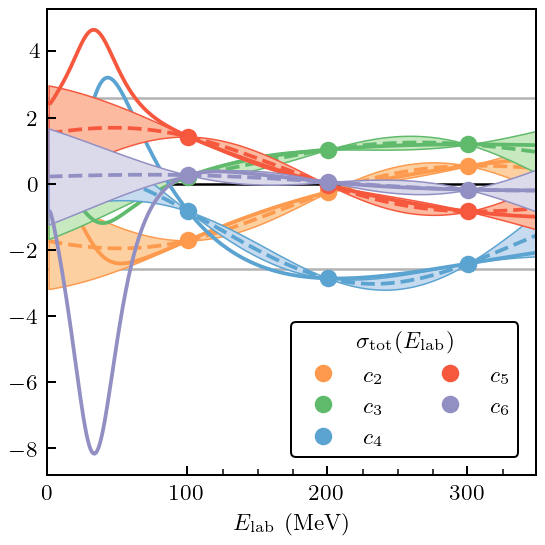

In [22]:
gp_sgt.fit(Tlab[tlab_train_mask_sgt], coeffs_sgt[tlab_train_mask_sgt])
pred, std = gp_sgt.predict(Tlab, return_std=True)
print(pred.shape)
underlying_std = np.sqrt(gp_sgt.cov_factor_)

fig, ax = plt.subplots(figsize=(3.2, 3.2))
for i, n in enumerate(nn_orders[1:]):
    ax.plot(t_lab, pred[:, i], c=colors[i], zorder=i-5, ls='--')
    ax.plot(t_lab, coeffs_sgt[:, i], c=colors[i], zorder=i-5)
    ax.plot(t_lab[tlab_train_mask_sgt], coeffs_sgt[tlab_train_mask_sgt, i], c=colors[i], zorder=i-5,
            ls='', marker='o', label=r'$c_{}$'.format(n))
    ax.fill_between(t_lab, pred[:, i] + 2*std, pred[:, i] - 2*std, zorder=i-5,
                     facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth, alpha=1)


# Format
ax.axhline(2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(-2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(0, 0, 1, c=softblack, zorder=-10, lw=1)
ax.set_xticks(t_lab[tlab_valid_mask_sgt], minor=True)
ax.tick_params(which='minor', bottom=True, top=False)
ax.set_xticks([0, 100, 200, 300])
ax.set_xlabel(r'$E_{\mathrm{lab}}$ (MeV)')
ax.legend(ncol=2, title=r'$\sigma_{\mathrm{tot}}(E_{\mathrm{lab}})$')
fig.tight_layout();
fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \
            'sgt_interp_and_underlying_processes_large_tlab' + '_' + potential_string + '_' + cutoff_string)

Already from the plot it is clear that $c_5$ is problematic, although that problem occurs only at low energy. This will show up as a large MD and, once again, PC errors at high index that are too large.

In [23]:
gp_sgt.kernel_

RBF(length_scale=121) + WhiteKernel(noise_level=1e-10)

In [24]:
mean_sgt = gp_sgt.mean(Tlab[tlab_valid_mask_sgt])
cov_sgt = gp_sgt.cov(Tlab[tlab_valid_mask_sgt])
gr_dgn_sgt = gm.GraphicalDiagnostic(coeffs_sgt[tlab_valid_mask_sgt], mean_sgt, cov_sgt, colors=colors, gray=gray,
                                   black=softblack)

C:\Users\pjmil\AppData\Local\Temp/ipykernel_24188/3918792140.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();


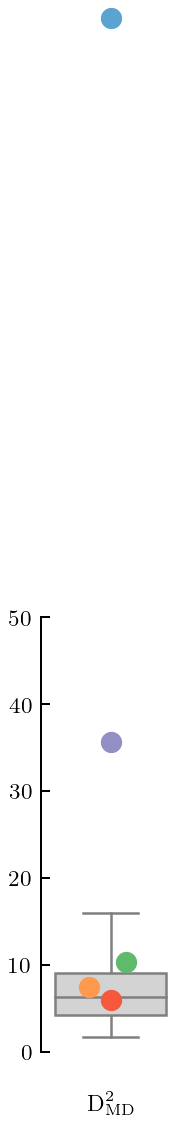

In [25]:
fig, ax = plt.subplots(figsize=(1, 3.2))
gr_dgn_sgt.md_squared(type='box', trim=False, title=None, xlabel=MD_label)
offset_xlabel(ax)
ax.set_ylim(0, 50)
fig.tight_layout();
fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \
            'sgt_md_large_tlab' + '_' + potential_string + '_' + cutoff_string)

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


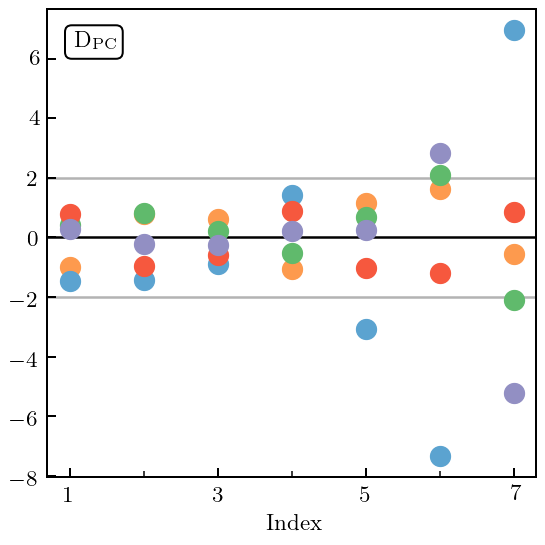

C:\Users\pjmil\AppData\Local\Temp/ipykernel_24188/3799554077.py:9: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \


In [26]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(figsize=(3.2, 3.2))
    gr_dgn_sgt.pivoted_cholesky_errors(ax=ax, title=None)
    ax.set_xticks([2, 4, 6], minor=True)
    ax.set_xticks([1, 3, 5, 7])
    ax.text(0.05, 0.95, PC_label, bbox=text_bbox, transform=ax.transAxes, va='top', ha='left')
    fig.tight_layout();
    plt.show()
    fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \
            'sgt_pc_vs_index_large_tlab' + '_' + potential_string + '_' + cutoff_string)

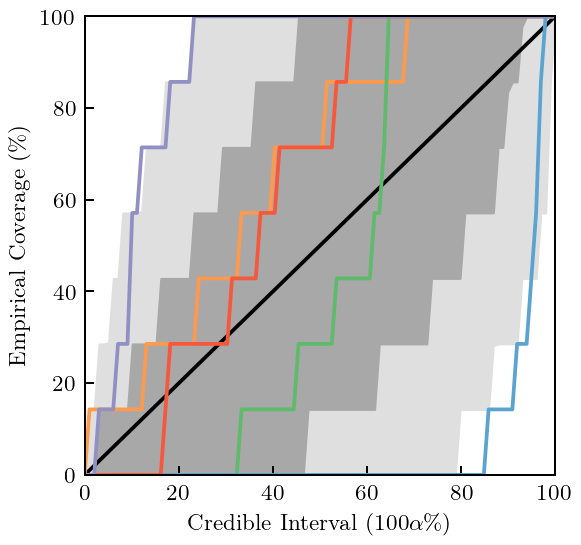

In [27]:
fig, ax = plt.subplots(figsize = (3.4, 3.2))

gr_dgn_sgt.credible_interval(
    np.linspace(1e-5, 1, 100), band_perc=[0.68, 0.95], ax = ax, title = None,
    xlabel = r'Credible Interval ($100\alpha\%$)', ylabel = r'Empirical Coverage ($\%$)')

ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 20, 40, 60, 80, 100])
fig.tight_layout()

fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \
            'truncation_error_credible_intervals_SGT' + '_' + potential_string + '_' + cutoff_string)

### Figure 13: Spin Observable $A$

Finally, we look at an observable that has a symmetry constraint. The spin observable $A$, for which we choose the energy $T_{\rm lab}=96$ MeV. $A(\theta=0)=0$ (in the absence of magnetic-moment interactions). 

In [107]:
t_lab_A = 96  # should match up with legend title in curve plot
t_lab_idx_A = np.nonzero(t_lab_A == t_lab)[0][0]
q_cm_A = q_cm[t_lab_idx_A]

nugget = 1e-10

degrees_train_mask_A, degrees_valid_mask_A = regular_train_test_split(degrees, dx_train=40, dx_test=10)

ratio_A = Q_approx(t_lab_A, Lambda_b=Lambdab)

A_train = A.T[degrees_train_mask_A, t_lab_idx_A]
A_valid = A.T[degrees_valid_mask_A, t_lab_idx_A]
A_vs_theta = A.T[:, t_lab_idx_A]

coeffs_A = gm.coefficients(A_vs_theta, ratio=ratio_A, orders=nn_orders)
length_scale_A = 30
kernel_A = RBF(length_scale=length_scale_A) + WhiteKernel(nugget, noise_level_bounds='fixed')

C:\Users\pjmil\anaconda3\lib\site-packages\gsum\models.py:665: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)


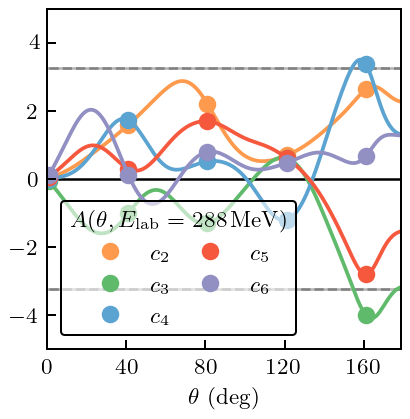

In [108]:
gp_coeffs_A = gm.ConjugateGaussianProcess(kernel=kernel_A, center=center0, disp=disp0, df=df0, scale=scale0)
gp_coeffs_A.fit(Deg[degrees_train_mask_A], coeffs_A[degrees_train_mask_A, 1:])

pred, std = gp_coeffs_A.predict(Deg, return_std=True)
underlying_std = np.sqrt(gp_coeffs_A.cov_factor_)

# Compute the std-dev under the symmetry constraint
dX_A = np.array([[0]])
std_interp = np.sqrt(np.diag(
    gp_coeffs_A.cov(Deg) -
    gp_coeffs_A.cov(Deg, dX_A) @ np.linalg.solve(gp_coeffs_A.cov(dX_A, dX_A), gp_coeffs_A.cov(dX_A, Deg))
))

fig, ax = plt.subplots(figsize=(2.45, 2.5))
for i, n in enumerate(nn_orders[1:]):
    ax.plot(degrees, coeffs_A[:, i+1], c=colors[i], zorder=i-5)
    ax.plot(degrees[degrees_train_mask_A], coeffs_A[degrees_train_mask_A, i+1], c=colors[i],
            zorder=i-5, ls='', marker='o', label=r'$c_{n}$'.format(n=n))


# Format
ax.axhline(2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.axhline(-2*underlying_std, 0, 1, c=gray, zorder=-10, lw=1)
ax.plot(degrees, 2*std_interp, color='gray', ls='--', zorder=-10, lw=1)
ax.plot(degrees, -2*std_interp, color='gray', ls='--', zorder=-10, lw=1)
ax.axhline(0, 0, 1, c=softblack, zorder=-10, lw=1)
ax.tick_params(which='minor', bottom=False, top=True)
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_xticks([0, 40, 80, 120, 160])
ax.set_ylim(-5, 5)
leg = ax.legend(ncol=2, borderpad=0.4, columnspacing=0.8, borderaxespad=0.6, \
               title = r'$A(\theta, E_{\mathrm{lab}}=96\,\mathrm{MeV})$')
# leg.legendPatch.set_facecolor('none')
# ax.text(0.055, 0.965, r'$A(\theta, E_{\mathrm{lab}}=96\,\mathrm{MeV})$', transform=ax.transAxes, va='top',
#         bbox=dict(boxstyle="round", ec=softblack, fc='white', lw=0.8))
fig.tight_layout();
fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \
            'spin_obs_A_coefficients' + '_' + str(t_lab_A) + 'MeVlab' + '_' + \
            potential_string + '_' + cutoff_string)

First we proceed as if we did not know that there was a symmetry at $\theta=0$.

In [109]:
gp_A = gm.TruncationGP(kernel_A, ref=1, ratio=ratio_A, center=center0, disp=disp0, df=df0, scale=scale0, excluded=excluded)

C:\Users\pjmil\anaconda3\lib\site-packages\gsum\models.py:665: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)


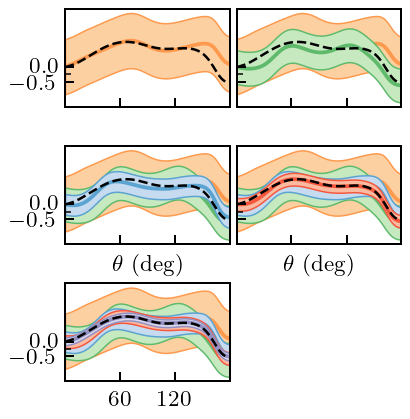

In [110]:
gp_A.fit(degrees[degrees_train_mask_A][:, None], A_train, orders=nn_orders)

fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(2.45, 2.5))
fig.delaxes(axes[2,1])
if potential_string == "EKM" or potential_string == "EMN":
    fig.delaxes(axes[2,0])

for i, n in enumerate(nn_orders[1:]):
    _, std_trunc = gp_A.predict(degrees[:, None], order=n, return_std=True, kind='trunc')
    
    for j in range(i, 5):
        ax = axes.ravel()[j]
        ax.plot(degrees, A_vs_theta[:, i+1], zorder=i-5, c=colors[i])
        ax.fill_between(degrees, A_vs_theta[:, i+1] + 2*std_trunc, A_vs_theta[:, i+1] - 2*std_trunc,
                        zorder=i-5, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.plot(degrees, A_nn_online[t_lab_idx_A], color=softblack, lw=1, ls='--')
    ax.set_xticks([60, 120])
    ax.set_yticks([-0.5, 0])
    ax.set_yticks([-0.25,], minor=True)

# Format
axes[1, 0].set_xlabel(r'$\theta$ (deg)')
axes[1, 1].set_xlabel(r'$\theta$ (deg)')
fig.tight_layout(h_pad=0.3, w_pad=0.3);
fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \
            'spin_obs_A_full_pred_unconstrained' + '_' + str(t_lab_A) + 'MeVlab' + '_' + \
            potential_string + '_' + cutoff_string)

And now we incorporate the constraint. We do not plot the revised coefficients, but only show the resulting EFT predictions, with truncation errors. The truncation errors now respect the symmetry constraint, because the GP does. 

C:\Users\pjmil\anaconda3\lib\site-packages\gsum\models.py:665: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)


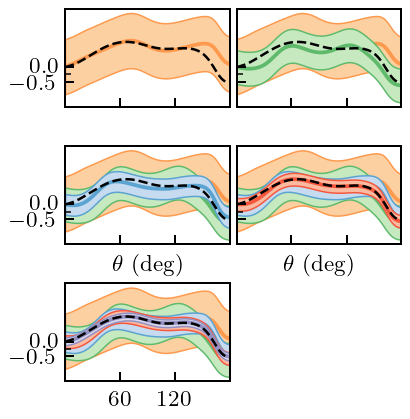

In [111]:
gp_A.fit(degrees[degrees_train_mask_A][:, None], A_train, orders=nn_orders, dX=np.array([[0]]), dy=[0])

fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(2.45, 2.5))
fig.delaxes(axes[2,1])
if potential_string == "EKM" or potential_string == "EMN":
    fig.delaxes(axes[2,0])
    
for i, n in enumerate(nn_orders[1:]):
    _, std_trunc = gp_A.predict(degrees[:, None], order=n, return_std=True, kind='trunc')
    
    for j in range(i, 5):
        ax = axes.ravel()[j]
        ax.plot(degrees, A_vs_theta[:, i+1], zorder=i-5, c=colors[i])
        ax.fill_between(degrees, A_vs_theta[:, i+1] + 2*std_trunc, A_vs_theta[:, i+1] - 2*std_trunc,
                        zorder=i-5, facecolor=light_colors[i], edgecolor=colors[i], lw=edgewidth)
    ax = axes.ravel()[i]
    ax.plot(degrees, A_nn_online[t_lab_idx_A], color=softblack, lw=1, ls='--')
    ax.set_xticks([60, 120])
    ax.set_yticks([-0.5, 0])
    ax.set_yticks([-0.25,], minor=True)

# Format
axes[1, 0].set_xlabel(r'$\theta$ (deg)')
axes[1, 1].set_xlabel(r'$\theta$ (deg)')
fig.tight_layout(h_pad=0.3, w_pad=0.3);
fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \
            'spin_obs_A_full_pred_constrained' + '_' + str(t_lab_A) + 'MeVlab' + '_' + \
            potential_string + '_' + cutoff_string)

In [112]:
# gp_A = gm.ConjugateGaussianProcess(
#     kernel_A, center = center0, disp = disp0, df = df0,
#     scale = scale0, n_restarts_optimizer = 10, random_state = 4)
# coeffs_A = gm.coefficients(A_vs_theta, ratio = ratio_A, ref = 1, orders = nn_orders)[:, nn_orders_mask]
# gp_A.kernel_
# mean_A = gp_A.mean(degrees[degrees_valid_mask_A])
# cov_A = gp_A.cov(degrees[degrees_valid_mask_A])
# gr_dgn_A = gm.GraphicalDiagnostic(coeffs_A[degrees_valid_mask_A], mean_A, cov_A, \
#                                   colors = colors, gray = gray, black = softblack)

In [113]:
# fig, ax = plt.subplots(figsize = (3.4, 3.2))

# gr_dgn_sgt.credible_interval(
#     np.linspace(1e-5, 1, 100), band_perc=[0.68, 0.95], ax = ax, title = None,
#     xlabel = r'Credible Interval ($100\alpha\%$)', ylabel = r'Empirical Coverage ($\%$)')

# ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# ax.set_xticklabels([0, 20, 40, 60, 80, 100])
# ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# ax.set_yticklabels([0, 20, 40, 60, 80, 100])
# fig.tight_layout()

# fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \
#             'truncation_error_credible_intervals_A' + '_' + potential_string + '_' + cutoff_string)

### Figure 9: The $Q$ and $\ell$ Posterior

Here we generate the 2D posterior for the EFT expansion parameter $Q$ and the GP lengthscale $\ell$.
We also show the 1D marginal distributions for $\Lambda_{b}$ and $\ell$. And all in one plot!

In [114]:
# Define the grid on which we want to plot the results
ls_vals = np.linspace(1e-6, 100, 100)
lambda_vals = np.linspace(300, 900, 300)

In [115]:
# Compute the log likelihood for values on this grid. 
ls_lambda_loglike = np.array([[
    gp_A.log_marginal_likelihood( theta=[ls_,], ratio = Q_approx(t_lab_A, Lambda_b = lambd) ) \
    for ls_ in np.log(ls_vals)]
    for lambd in lambda_vals])

In [116]:
# Makes sure that the values don't get too big or too small
ls_lambda_like = np.exp(ls_lambda_loglike - np.max(ls_lambda_loglike))

# Now compute the marginal distributions
lambda_like = np.trapz(ls_lambda_like, x = ls_vals, axis = -1)
ls_like = np.trapz(ls_lambda_like, x = lambda_vals, axis = 0)

# Normalize them
lambda_like /= np.trapz(lambda_like, x = lambda_vals, axis = 0)
ls_like /= np.trapz(ls_like, x = ls_vals, axis = 0)

In [117]:
def joint_plot(ratio = 1, height = 3):
    """Taken from Seaborn JointGrid"""
    fig = plt.figure(figsize=(height, height))
    gsp = plt.GridSpec(ratio+1, ratio+1)

    ax_joint = fig.add_subplot(gsp[1:, :-1])
    ax_marg_x = fig.add_subplot(gsp[0, :-1], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(gsp[1:, -1], sharey=ax_joint)

    # Turn off tick visibility for the measure axis on the marginal plots
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Turn off the ticks on the density axis for the marginal plots
    plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_x.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    ax_marg_x.yaxis.grid(False)
    ax_marg_y.xaxis.grid(False)

    # Make the grid look nice
    from seaborn import utils
    # utils.despine(fig)
    utils.despine(ax=ax_marg_x, left=True)
    utils.despine(ax=ax_marg_y, bottom=True)
    fig.tight_layout(h_pad=0, w_pad=0)
    
    ax_marg_y.tick_params(axis='y', which='major', direction='out')
    ax_marg_x.tick_params(axis='x', which='major', direction='out')
    ax_marg_y.tick_params(axis='y', which='minor', direction='out')
    ax_marg_x.tick_params(axis='x', which='minor', direction='out')
    ax_marg_y.margins(x=0.1, y=0.)

    fig.subplots_adjust(hspace=0, wspace=0)
    
    return fig, ax_joint, ax_marg_x, ax_marg_y

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


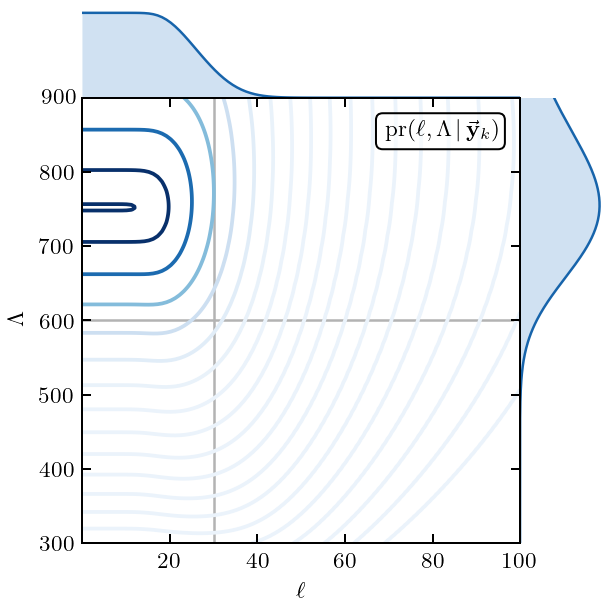

C:\Users\pjmil\AppData\Local\Temp/ipykernel_24188/1612018232.py:41: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \


In [118]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    cmap_name = 'Blues'
    cmap = mpl.cm.get_cmap(cmap_name)

    # Setup axes
    fig, ax_joint, ax_marg_x, ax_marg_y = joint_plot(ratio=5, height=3.4)

    # Plot contour
    ax_joint.contour(ls_vals, lambda_vals, ls_lambda_like,
                     levels=[np.exp(-0.5*r**2) for r in np.arange(9, 0, -0.5)] + [0.999],
                     cmap=cmap_name, vmin=-0.05, vmax=0.8, zorder=1)

    # Now plot the marginal distributions
    ax_marg_y.plot(lambda_like, lambda_vals, c=cmap(0.8), lw=1)
    ax_marg_y.fill_betweenx(lambda_vals, np.zeros_like(lambda_like),
                            lambda_like, facecolor=cmap(0.2), lw=1)
    ax_marg_x.plot(ls_vals, ls_like, c=cmap(0.8), lw=1)
    ax_marg_x.fill_between(ls_vals, np.zeros_like(ls_vals),
                           ls_like, facecolor=cmap(0.2), lw=1)

    # Formatting
    ax_joint.set_xlabel(r'$\ell$')
    ax_joint.set_ylabel(r'$\Lambda$')
    ax_joint.axvline(length_scale_A, 0, 1, c=gray, lw=1, zorder=0)
    ax_joint.axhline(Lambdab, 0, 1, c=gray, lw=1, zorder=0)
    ax_joint.margins(x=0, y=0.)
    ax_joint.set_xlim(min(ls_vals), max(ls_vals))
    ax_joint.set_ylim(min(lambda_vals), max(lambda_vals))
#     ax_joint.set_xticks([0.1, 0.2, 0.3])
#     ax_joint.set_xticks([0.15, 0.25], minor=True)
#     ax_joint.set_yticks([0.4, 0.5, 0.6])
#     ax_joint.set_yticks([0.35, 0.45, 0.55, 0.65], minor=True)
    ax_marg_x.set_ylim(bottom=0);
    ax_marg_y.set_xlim(left=0);
    ax_joint.text(0.95, 0.95, r'pr$(\ell, \Lambda \,|\, \vec{\mathbf{y}}_k)$', ha='right', va='top',
                  transform=ax_joint.transAxes,
                  bbox=text_bbox
                 );

    plt.show()
    fig.savefig('figures/' + potential_string + '_' + cutoff_string + '/' + \
            'Lambda_ell_jointplot' + '_' + 'A' + '_' + str(t_lab_A) + 'MeVlab' + '_' + \
                potential_string + '_' + cutoff_string)